In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

from transformers import AutoTokenizer
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {0: "negative", 1: "neutral", 2: "positive"}

## Data preparation
[SemEval-2014 Task 4: Aspect Based Sentiment Analysis](https://aclanthology.org/S14-2004/) (Pontiki et al., SemEval 2014)

In [4]:
#Dataset from https://huggingface.co/datasets/tomaarsen/setfit-absa-semeval-laptops
splits = {'train': 'data/train-00000-of-00001.parquet', 'test': 'data/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/tomaarsen/setfit-absa-semeval-laptops/" + splits["train"])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
df.rename(columns={"span": "aspect"}, inplace=True)
df = df[['text', 'aspect', 'label']]
df = df[df["label"] != "conflict"]
df = df.dropna()

## Basic information of the dataset
Such as text lengths, unique values, common aspects and value counts.

In [ ]:
df

,text,aspect,label
0,I charge it at night and skip taking the cord ...,cord,neutral
1,I charge it at night and skip taking the cord ...,battery life,positive
2,The tech guy then said the service center does...,service center,negative
3,The tech guy then said the service center does...,"""sales"" team",negative
4,The tech guy then said the service center does...,tech guy,neutral
...,...,...,...
2352,We also use Paralles so we can run virtual mac...,Windows 7 Home Premium,neutral
2353,We also use Paralles so we can run virtual mac...,Windows Server Enterprise 2003,neutral
2354,We also use Paralles so we can run virtual mac...,Windows Server 2008 Enterprise,neutral
2356,"How Toshiba handles the repair seems to vary, ...",repair,positive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2313 entries, 0 to 2357
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2313 non-null   object
 1   aspect  2313 non-null   object
 2   label   2313 non-null   object
dtypes: object(3)
memory usage: 72.3+ KB


In [ ]:
df.nunique()

,0
text,1456
aspect,1031
label,3


In [ ]:
df['label'].value_counts()

,count
label,
positive,987
negative,866
neutral,460


In [6]:
print(f"Minimum length: {df['text'].apply(len).min()} char")
print(f"Average length: {df['text'].apply(len).mean():.1f} char")
print(f"Maximum length: {df['text'].apply(len).max()} char")
print(f"Minimum length: {df['text'].apply(lambda s: len(s.split())).min()} words")
print(f"Average length: {df['text'].apply(lambda s: len(s.split())).mean():.1f} words")
print(f"Maximum length: {df['text'].apply(lambda s: len(s.split())).max()} words")

Minimum length: 11 char
Average length: 104.8 char
Maximum length: 464 char
Minimum length: 2 words
Average length: 19.3 words
Maximum length: 78 words


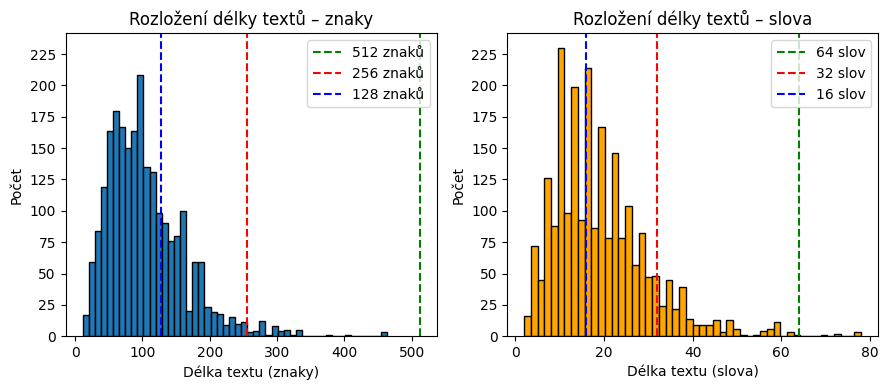

In [ ]:
# Graphs for lengths of text, in characters and in words
dff = df.copy()
dff["char_len"] = dff["text"].apply(len)
dff["word_len"] = dff["text"].apply(lambda s: len(s.split()))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

axes[0].hist(dff["char_len"], bins=50, edgecolor="black")
axes[0].axvline(512,  color="g", linestyle="--", label="512 znaků")
axes[0].axvline(256,  color="r", linestyle="--", label="256 znaků")
axes[0].axvline(128,  color="b", linestyle="--", label="128 znaků")
axes[0].set_xlabel("Délka textu (znaky)")
axes[0].set_ylabel("Počet")
axes[0].set_title("Rozložení délky textů – znaky")
axes[0].legend()

axes[1].hist(dff["word_len"], bins=50, edgecolor="black", color="orange")
axes[1].axvline(64,  color="g", linestyle="--", label="64 slov")
axes[1].axvline(32,  color="r", linestyle="--", label="32 slov")
axes[1].axvline(16,  color="b", linestyle="--", label="16 slov")
axes[1].set_xlabel("Délka textu (slova)")
axes[1].set_ylabel("Počet")
axes[1].set_title("Rozložení délky textů – slova")
axes[1].legend()

max_y = max(axes[0].get_ylim()[1], axes[1].get_ylim()[1])
axes[0].set_ylim(0, max_y)
axes[1].set_ylim(0, max_y)

axes[0].set_yticks(range(0, int(max_y), 25))
axes[1].set_yticks(range(0, int(max_y), 25))

plt.tight_layout()
plt.show()

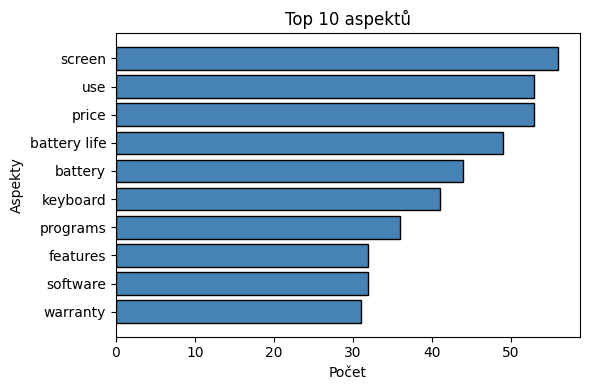

In [ ]:
# Find the TOP 10 aspects
topN = 10
cat_counts = (df["aspect"].value_counts().head(topN).sort_values(ascending=True))

aspects = cat_counts.index.tolist()
frequencies = cat_counts.values.tolist()

plt.figure(figsize=(6, 4))

bar_color = "steelblue"
y_pos = range(len(aspects))

plt.barh(y_pos, frequencies, color=bar_color, edgecolor="black")
plt.yticks(y_pos, aspects)
plt.xlabel("Počet")
plt.ylabel("Aspekty")
plt.title(f"Top {topN} aspektů")
plt.tight_layout()
plt.show()

## Data seperation into train, val, test subsets

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=1/3, random_state=42)
train_df.to_csv("/content/drive/MyDrive/Newton/data/SemEval-2014/train.csv", index=False)
val_df.to_csv("/content/drive/MyDrive/Newton/data/SemEval-2014/val.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Newton/data/SemEval-2014/test.csv", index=False)
print(f"Train set size: {train_df.shape[0]}")
print(f"Validation set size: {val_df.shape[0]}")
print(f"Test set size: {test_df.shape[0]}")

Train set size: 1619
Validation set size: 462
Test set size: 232


In [ ]:
print(f"Train set size: {train_df['label'].value_counts()}")
print(f"Validation set size: {val_df['label'].value_counts()}")
print(f"Test set size: {test_df['label'].value_counts()}")

Train set size: label
positive    719
negative    600
neutral     300
Name: count, dtype: int64
Validation set size: label
negative    185
positive    173
neutral     104
Name: count, dtype: int64
Test set size: label
positive    95
negative    81
neutral     56
Name: count, dtype: int64


## Difference of tokens needed for each sentence in the dataset usign differen tokenizers
For large version of models wont be shown any graphs, as they are usually usign the same tokenizer, just having more parameters

In [ ]:
dataset = Dataset.from_pandas(df)

In [ ]:
# Function for printing graphs for the length of tokenized sentences
def plot_tokenized_text(tokenizername, data):
    tokenizer = AutoTokenizer.from_pretrained(tokenizername)

    def tokenize_function(example):
        combined_input = f"aspect: {example['aspect']} text: {example['text']}"

        encoding = tokenizer(
            combined_input,
            truncation=True,
            max_length=256
        )
        # Convert label from string to int
        encoding["label"] = label2id[example["label"]]
        return encoding

    def tokenize_functionQA(example):
        question_string = f"What is the sentiment of aspect: {example['aspect']}?"

        encoding = tokenizer(
            text=example["text"],
            text_pair=question_string,
            truncation=True,
            max_length=256
        )
        # Convert label from string to int
        encoding["label"] = label2id[example["label"]]
        return encoding

    def getLength(dataset):
        lengths = []
        for i in range(len(dataset)):
          lengths.append(len(dataset[i]))
        return lengths

    dataset = data.map(tokenize_function, batched=False, )
    datasetQA = data.map(tokenize_functionQA, batched=False)

    length = getLength(dataset['input_ids'])
    lengthQA = getLength(datasetQA['input_ids'])

    print(f"The maximum length of tokenized text in dataset with {tokenizername}: " + str(max(length)))
    print(f"The maximum length of tokenized text in dataset with {tokenizername} using QA: " + str(max(lengthQA)))

    global_max = max(max(length), max(lengthQA))
    global_min = min(min(length), min(lengthQA))
    bin_edges  = np.linspace(global_min, global_max, 50 + 1)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    counts1, _, _ = axes[0].hist(length, bins=bin_edges, edgecolor="black", color="steelblue", label='_nolegend_')
    counts2, _, _ = axes[1].hist(lengthQA, bins=bin_edges, edgecolor="black", color="forestgreen", label='_nolegend_')

    axes[0].set_title(tokenizername)
    axes[0].set_xlabel("Délka textu (tokeny)")
    axes[0].set_ylabel("Počet")

    axes[1].set_title(tokenizername + "QA")
    axes[1].set_xlabel("Délka textu (tokeny)")
    axes[1].set_ylabel("Počet")

    ymax = max(counts1.max(), counts2.max()) + 20
    axes[0].set_ylim(0, ymax)
    axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()

The maximum length of tokenized text in dataset with bert-base-uncased: 97
The maximum length of tokenized text in dataset with bert-base-uncased using QA: 102


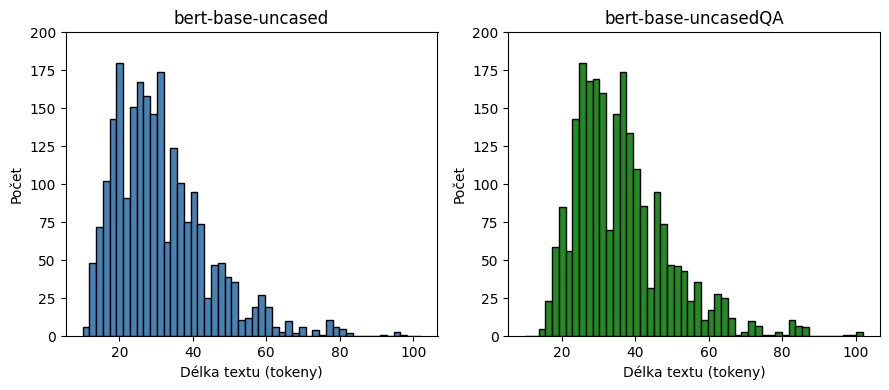

In [ ]:
plot_tokenized_text("bert-base-uncased", dataset)

The maximum length of tokenized text in dataset with bert-base-multilingual-cased: 106
The maximum length of tokenized text in dataset with bert-base-multilingual-cased using QA: 111


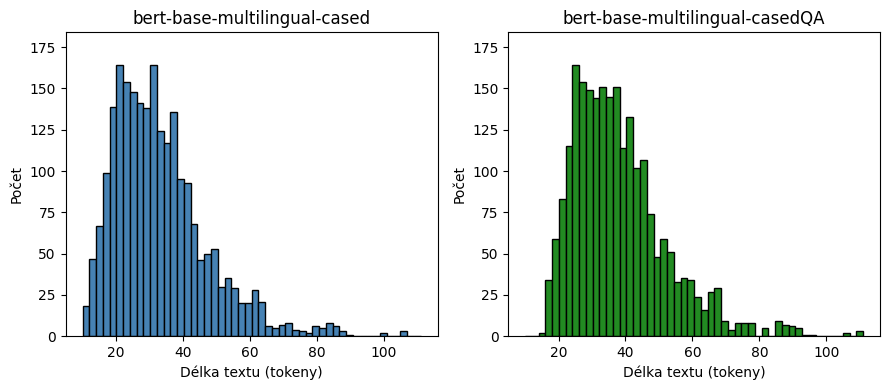

In [ ]:
plot_tokenized_text("bert-base-multilingual-cased", dataset)

The maximum length of tokenized text in dataset with roberta-base: 98
The maximum length of tokenized text in dataset with roberta-base using QA: 103


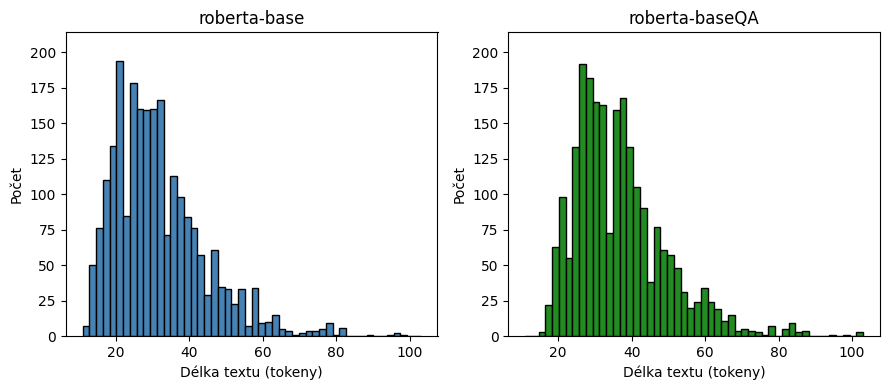

In [ ]:
plot_tokenized_text("roberta-base", dataset)

The maximum length of tokenized text in dataset with xlm-roberta-base: 107
The maximum length of tokenized text in dataset with xlm-roberta-base using QA: 113


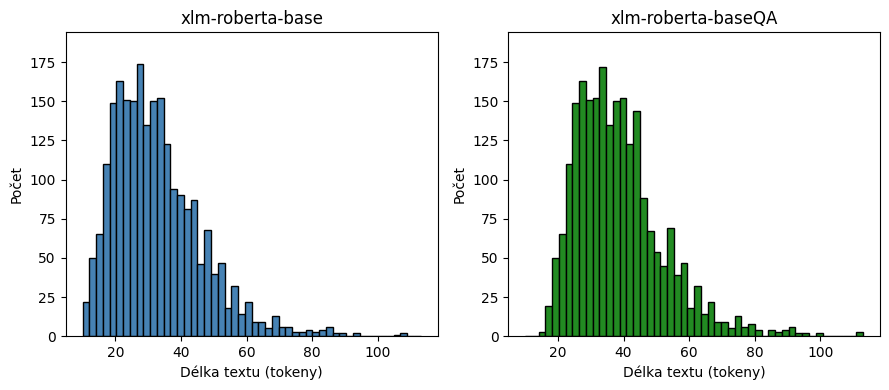

In [ ]:
plot_tokenized_text("xlm-roberta-base", dataset)

The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 97
The maximum length of tokenized text in dataset with microsoft/deberta-v3-base using QA: 102


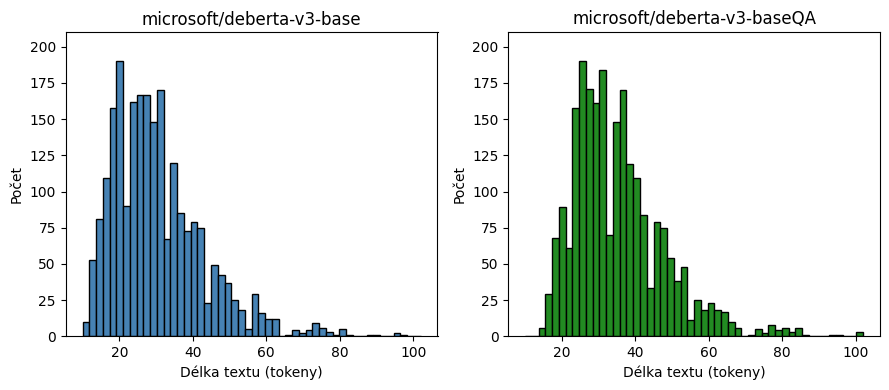

In [ ]:
plot_tokenized_text("microsoft/deberta-v3-base", dataset)

The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base: 99
The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base using QA: 103


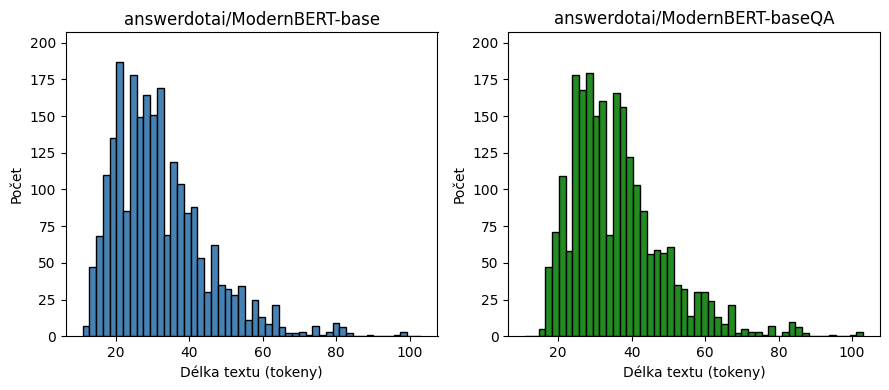

In [ ]:
plot_tokenized_text("answerdotai/ModernBERT-base", dataset)

The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased: 146
The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased using QA: 151


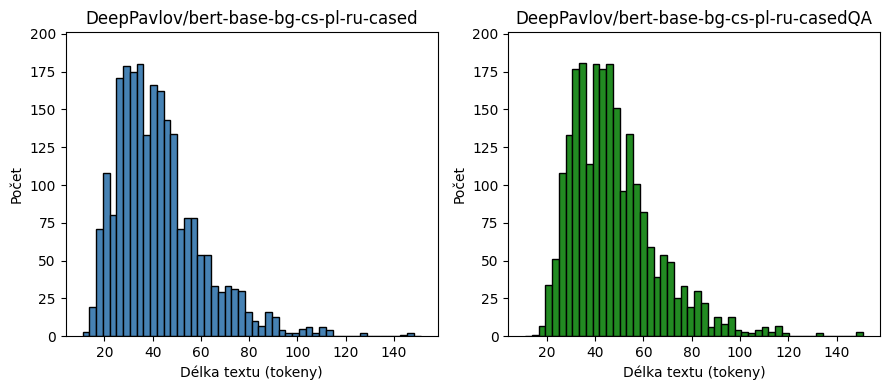

In [ ]:
plot_tokenized_text("DeepPavlov/bert-base-bg-cs-pl-ru-cased", dataset)

The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 144
The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased using QA: 151


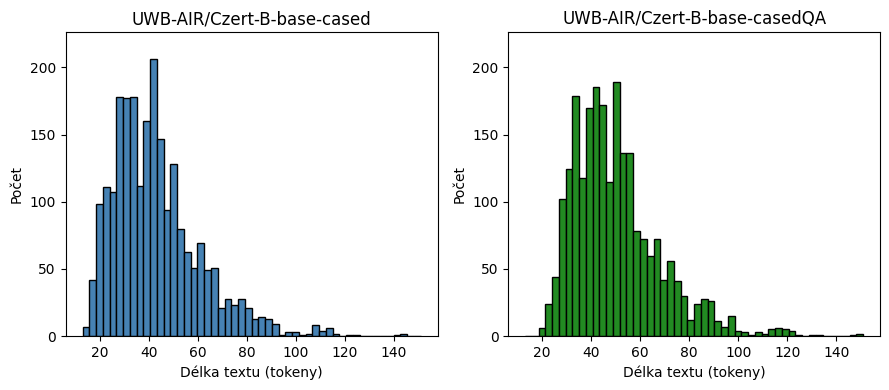

In [ ]:
plot_tokenized_text("UWB-AIR/Czert-B-base-cased", dataset)

The maximum length of tokenized text in dataset with ufal/robeczech-base: 169
The maximum length of tokenized text in dataset with ufal/robeczech-base using QA: 176


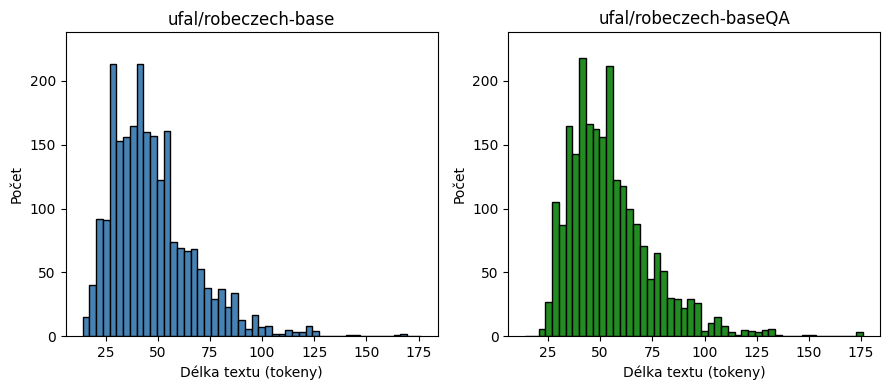

In [ ]:
plot_tokenized_text("ufal/robeczech-base", dataset)

The maximum length of tokenized text in dataset with fav-kky/FERNET-C5: 141
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5 using QA: 146


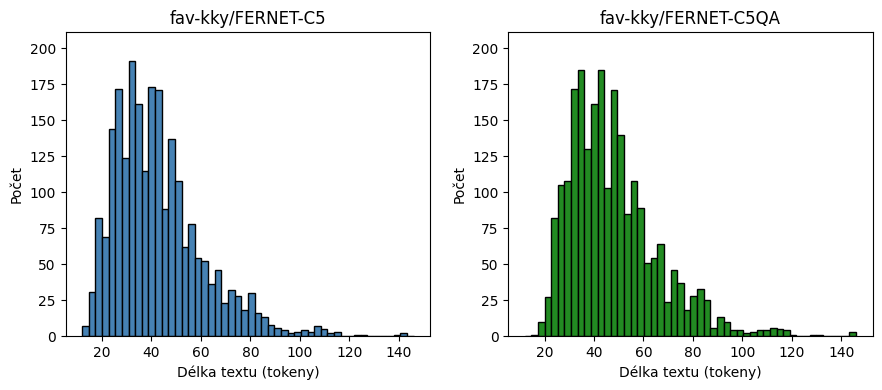

In [ ]:
plot_tokenized_text("fav-kky/FERNET-C5", dataset)

The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 192
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa using QA: 200


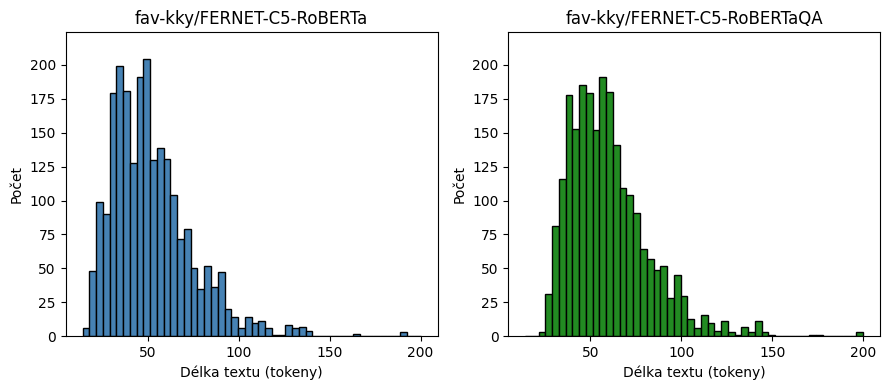

In [ ]:
plot_tokenized_text("fav-kky/FERNET-C5-RoBERTa", dataset)

In [ ]:
# Function for printing graphs for comparing the length of different tokenizors
def plot_tokenized_text_comparison(tokenizername1, tokenizername2, data):
    tokenizer1 = AutoTokenizer.from_pretrained(tokenizername1)
    tokenizer2 = AutoTokenizer.from_pretrained(tokenizername2)

    def encode(tokenizer):
        def tokenize(example):
            combined = f"aspect: {example['aspect']} text: {example['text']}"
            out = tokenizer(combined, truncation=True, max_length=512)
            out["label"] = label2id[example["label"]]
            return out
        return tokenize

    def getLength(dataset):
        lengths = []
        for i in range(len(dataset)):
          lengths.append(len(dataset[i]))
        return lengths

    dataset1 = data.map(encode(tokenizer1), batched=False, )
    dataset2 = data.map(encode(tokenizer2), batched=False)

    length1 = getLength(dataset1['input_ids'])
    length2 = getLength(dataset2['input_ids'])

    print(f"The maximum length of tokenized text in dataset with {tokenizername1}: " + str(max(length1)))
    print(f"The maximum length of tokenized text in dataset with {tokenizername2}: " + str(max(length2)))

    global_max = max(max(length1), max(length2))
    global_min = min(min(length1), min(length2))
    bin_edges  = np.linspace(global_min, global_max, 50 + 1)

    fig, axes = plt.subplots(1, 2, figsize=(9, 4))

    counts1, _, _ = axes[0].hist(length1, bins=bin_edges, edgecolor="black", color="steelblue", label='_nolegend_')
    counts2, _, _ = axes[1].hist(length2, bins=bin_edges, edgecolor="black", color="forestgreen", label='_nolegend_')

    axes[0].set_title(tokenizername1)
    axes[0].set_xlabel("Délka textu (tokeny)")
    axes[0].set_ylabel("Počet")

    axes[1].set_title(tokenizername2)
    axes[1].set_xlabel("Délka textu (tokeny)")
    axes[1].set_ylabel("Počet")

    ymax = max(counts1.max(), counts2.max()) + 20
    axes[0].set_ylim(0, ymax)
    axes[1].set_ylim(0, ymax)

    plt.tight_layout()
    plt.show()

Comparison between the most effective tokenizer vs the least effective tokenizer

The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 192
The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 97


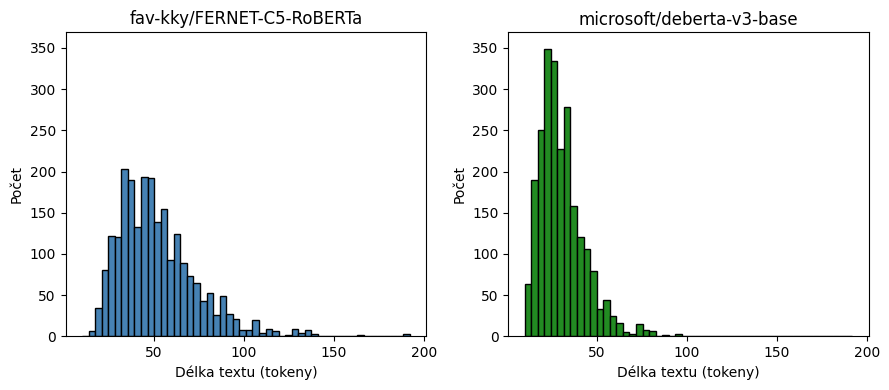

In [ ]:
plot_tokenized_text_comparison("fav-kky/FERNET-C5-RoBERTa", "microsoft/deberta-v3-base", dataset)

### Comparison between tokenizors of different languages
Comparing same models architectures, but with regard to their differnet trainig datasets

#### BERT models

The maximum length of tokenized text in dataset with bert-base-uncased: 97
The maximum length of tokenized text in dataset with bert-base-multilingual-cased: 106


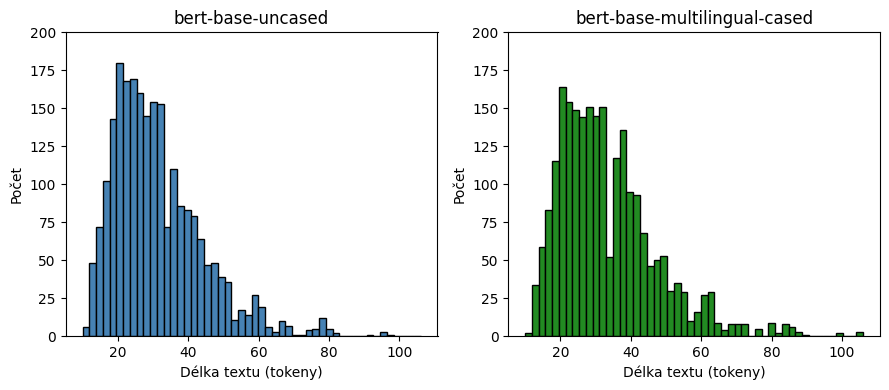

In [ ]:
plot_tokenized_text_comparison("bert-base-uncased", "bert-base-multilingual-cased", dataset)

The maximum length of tokenized text in dataset with DeepPavlov/bert-base-bg-cs-pl-ru-cased: 146
The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 144


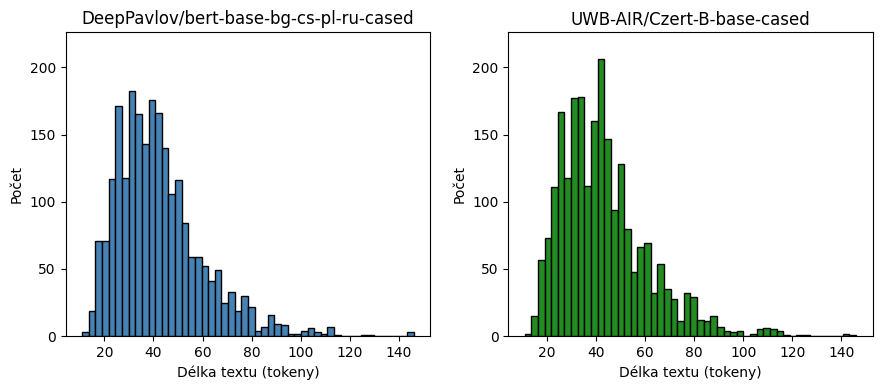

In [ ]:
plot_tokenized_text_comparison("DeepPavlov/bert-base-bg-cs-pl-ru-cased", "UWB-AIR/Czert-B-base-cased", dataset)

The maximum length of tokenized text in dataset with UWB-AIR/Czert-B-base-cased: 144
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5: 141


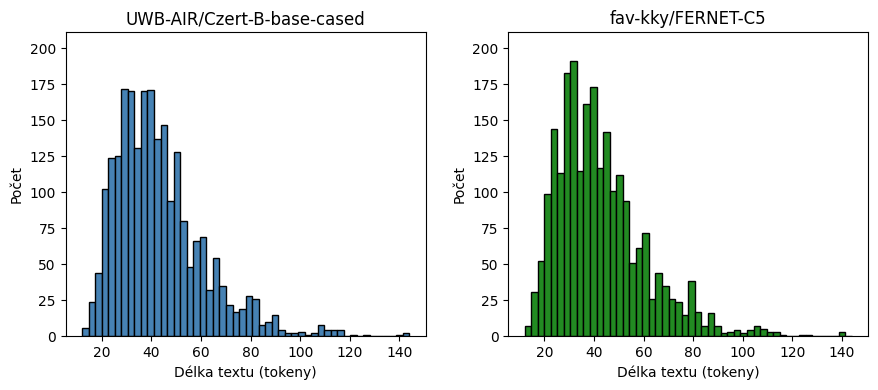

In [ ]:
plot_tokenized_text_comparison("UWB-AIR/Czert-B-base-cased", "fav-kky/FERNET-C5", dataset)

#### RoBERTa models

The maximum length of tokenized text in dataset with roberta-base: 98
The maximum length of tokenized text in dataset with xlm-roberta-base: 107


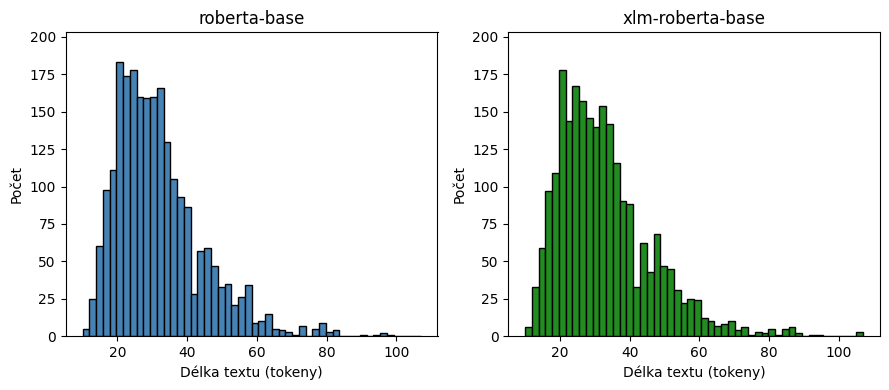

In [ ]:
plot_tokenized_text_comparison("roberta-base", "xlm-roberta-base", dataset)

The maximum length of tokenized text in dataset with ufal/robeczech-base: 169
The maximum length of tokenized text in dataset with fav-kky/FERNET-C5-RoBERTa: 192


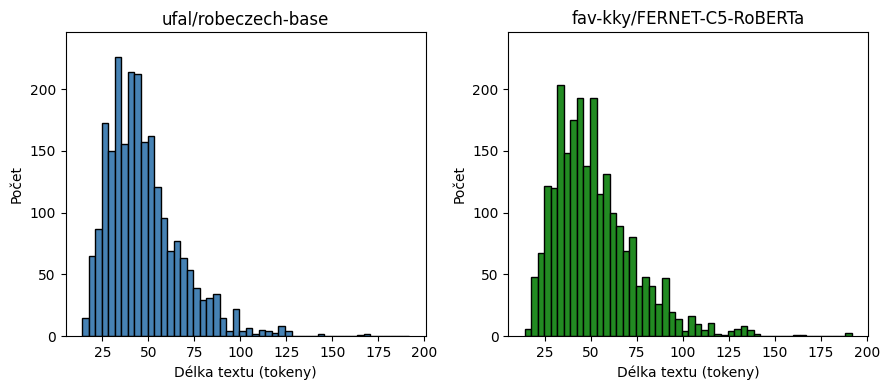

In [ ]:
plot_tokenized_text_comparison("ufal/robeczech-base", "fav-kky/FERNET-C5-RoBERTa", dataset)

#### DeBERTaV3 vs ModernBERT - newest English models

The maximum length of tokenized text in dataset with microsoft/deberta-v3-base: 97
The maximum length of tokenized text in dataset with answerdotai/ModernBERT-base: 99


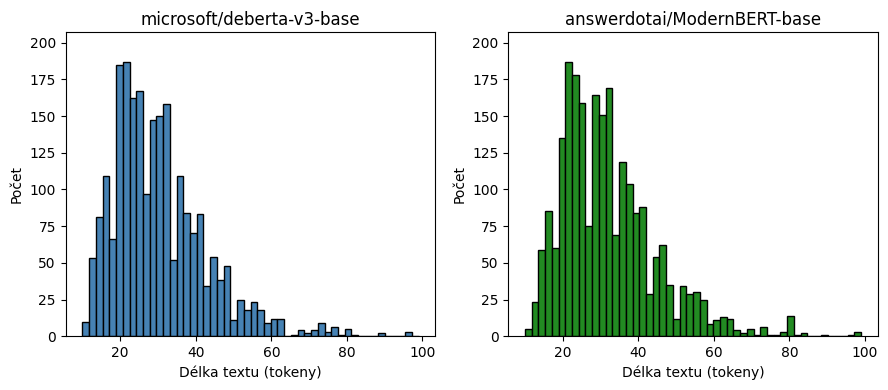

In [ ]:
plot_tokenized_text_comparison("microsoft/deberta-v3-base", "answerdotai/ModernBERT-base", dataset)